# Training a Single Layer Neural Network with Time Series Data

## Imports

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)
    
    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)
    
    # Label the x-axis
    plt.xlabel("Time")
    
    # Overlay a grid on the graph
    plt.grid(True)
    
    # Draw the graph on screen
    plt.show()
    
def trend(time, slope=0):
    # Compute the linear series given the slope
    series = slope * time
    
    return series

def seasonal_pattern(season_time):
    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    # Define the measured values per period
    season_time = ((time + phase) % period) / period
    
    # Generate the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)
    
    return data_pattern

def noise(time, noise_level=1, seed=None):
    # Initialize the random number generator
    rnd = np.random.RandomState(seed)
    
    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

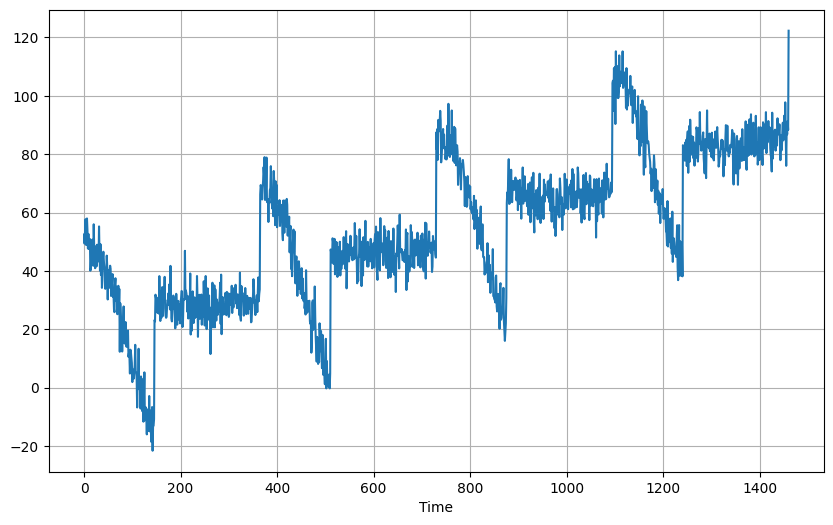

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

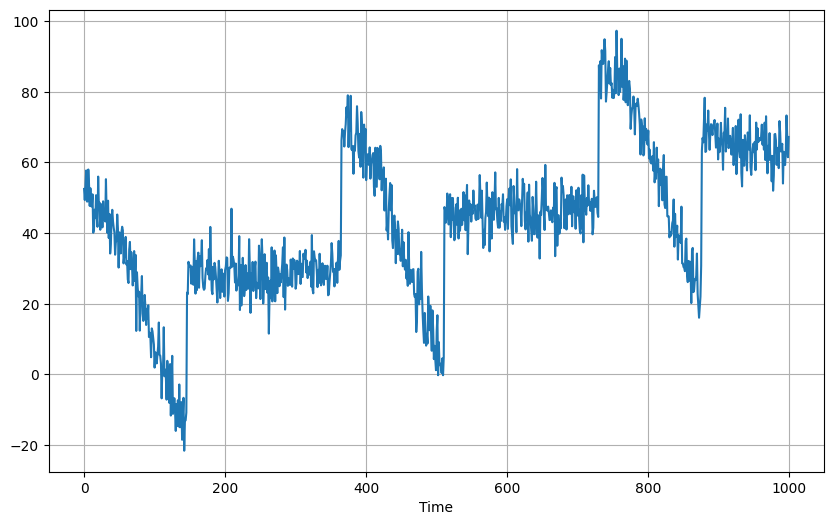

In [5]:
# Plot the train set
plot_series(time_train, x_train)

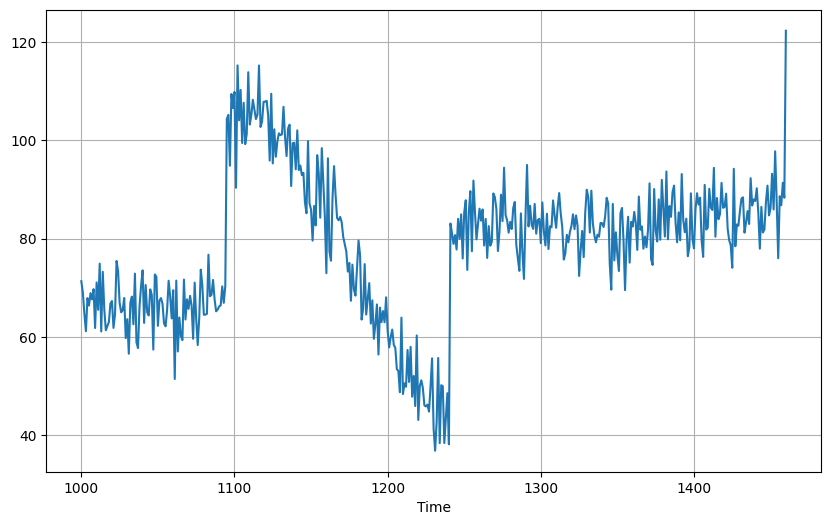

In [6]:
# Plot the validation set
plot_series(time_valid, x_valid)

## Prepare features and labels

In [7]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series value
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [10]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
# Print properties of a single batch
for windows in dataset.take(1):
    print(f'data type: {type(windows)}')
    print(f'number of elements in the tuple: {len(windows)}')
    print(f'shape of first element: {windows[0].shape}')
    print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model

In [15]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[ 0.24647397],
       [ 0.42418242],
       [-0.48916018],
       [ 0.32149327],
       [-0.42849475],
       [-0.2409887 ],
       [ 0.32019615],
       [-0.46668738],
       [-0.20856807],
       [ 0.0119195 ],
       [ 0.33477098],
       [-0.11090308],
       [-0.1766038 ],
       [-0.3013939 ],
       [ 0.07324481],
       [-0.14045733],
       [ 0.11976755],
       [ 0.12933362],
       [ 0.23597747],
       [ 0.15160197]], dtype=float32), array([0.], dtype=float32)] 



C:\Users\nandi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Set the training parameters
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

## Train the Model

In [18]:
# Train the model
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1284.4257
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 153.6868
Epoch 3/100


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95.7624   
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91.1259  
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 94.0915 
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 87.7656
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 85.5896 
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 85.8119 
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 85.6380
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84.2667   
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80.3115  
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.3280  
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72.1281  
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 76.0784 
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.5453   
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 70.1855
Epoch 17/100
31/31 ━━━━━━━━━━━━━

In [19]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.0324601 ],
       [ 0.05059068],
       [-0.05616407],
       [ 0.05390608],
       [-0.03709086],
       [-0.00760851],
       [ 0.0790325 ],
       [-0.05531504],
       [-0.04209999],
       [ 0.03562836],
       [ 0.06547655],
       [-0.02140376],
       [-0.05624971],
       [ 0.00217917],
       [ 0.0569809 ],
       [ 0.0343854 ],
       [ 0.04630669],
       [ 0.15744603],
       [ 0.30217367],
       [ 0.42586735]], dtype=float32), array([0.01244641], dtype=float32)]


## Model Prediction

In [20]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
model prediction: [[44.715336]]


In [22]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


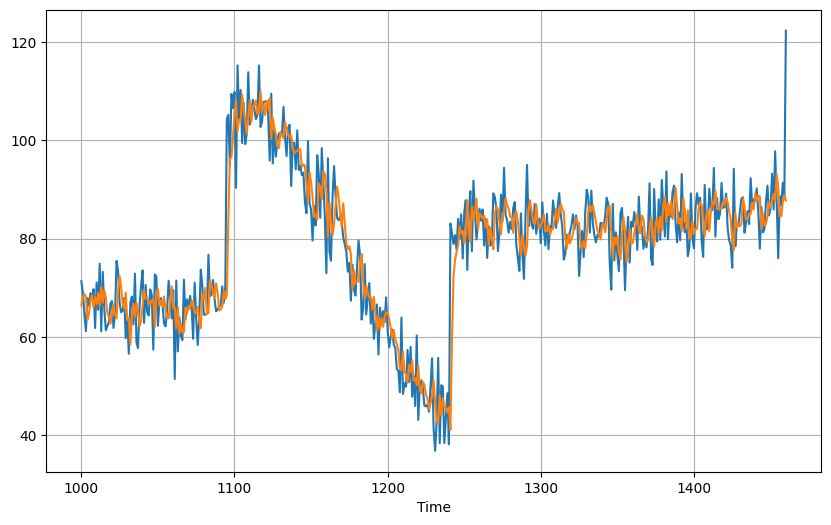

In [23]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [24]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

45.68919
5.020758
